<a href="https://colab.research.google.com/github/SarahGhysels/SarahGhysels_thesis_2024/blob/Thesis/ThesisSarahGhysels_CNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional neural network

## Preparation

###Installing files and importing functions

In [ ]:
#installing necessary files
%pip install split-folders tqdm
%pip install Augmentor

In [ ]:
#Linking google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
#Importing necessary functions
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import optim
from torchvision import datasets
from collections import OrderedDict
import Augmentor
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from google.colab import files
import pandas as pd
import random
import shutil
import cv2
from torch.utils.data import Dataset, DataLoader, Subset
import splitfolders
import re
from sklearn import metrics
from torchvision import models
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights, resnet50, ResNet50_Weights, densenet161, DenseNet161_Weights, vgg16, VGG16_Weights

### Defining functions

#### Dataset and dataloader

In [ ]:
#Create PyTorch dataset
class imagedataset(Dataset):
    def __init__(self, y_values, dir_image,id_image, transform=None):
        # csv_file (string): Path to the csv file with annotations, root_dir (string): Directory with all the images
        self.DMY_dataframe = y_values
        self.dir_image = dir_image
        self.transform = transform
        self.id_image = id_image
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
      return len(self.DMY_dataframe)

    def __getitem__(self, idx):
        image = cv2.imread(self.dir_image[idx])
        image = self.to_tensor(image)
        DMYield = self.DMY_dataframe[idx,]
        id_image = self.id_image[idx]

        if self.transform:
            image = self.transform(image)

        return image, DMYield, id_image

In [ ]:
def data_loader(train_dataset, val_dataset, test_dataset, batch_size = 256, workers = 1, pin_memory = True): #test_dataset

  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size = batch_size,
      shuffle = True,
      num_workers = workers,
      pin_memory = pin_memory,
      sampler = None
  )

  val_loader = torch.utils.data.DataLoader(
      val_dataset,
      batch_size = batch_size,
      shuffle = False,
      num_workers = workers,
      pin_memory = pin_memory
  )

  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size = batch_size,
      shuffle = False,
      num_workers = workers,
      pin_memory = pin_memory
  )

  return train_loader, val_loader , test_loader

#### Oversampling and data augmentation

In [ ]:
#Function to generate extra data by oversampling with Augmentor (creates new images by geometric transformations of existing ones)
def oversample_func(split_directory, folders, target_folders, requiredNbrOfImages):
    for i in range(len(folders)):
        path, dirs, files = next(os.walk(folders[i]))
        nbrOfImages = len(files)
        nbrOfImagesNeeded = requiredNbrOfImages - nbrOfImages

        if nbrOfImagesNeeded > 0:
            tfd = target_folders[i]
            print ("saving in " + tfd)
            p = Augmentor.Pipeline(source_directory=folders[i], output_directory=tfd)
            p.flip_left_right(probability=0.5)
            p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
            p.flip_left_right(probability=0.5)
            p.sample(nbrOfImagesNeeded, multi_threaded=False) #multithreading is a way of achieving multitasking

#### Model

##### Pretrained models

In [ ]:
# Functie geeft gewenste CNN model terug
def make_model(structure, preTrained):
  output_size = 3
  if structure=="densenet161":
      weights = models.DenseNet161_Weights.DEFAULT
      model = models.densenet161(weights=weights)
      input_size = 2208
      new_classifier =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(2208, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('fc3', nn.Linear(700, output_size)),
                            ('output', nn.Softmax(dim=1))]))

      model.classifier = new_classifier
  elif structure=="vgg16":
      weights = models.VGG16_Weights.DEFAULT
      model = models.vgg16(weights=weights)
      input_size = 25088
      new_classifier =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(25088, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('fc3', nn.Linear(700, output_size)),
                            ('output', nn.Softmax(dim=1))])) #logsoftmax is the same as normal softmax but computationally more efficient and numerically stable

      model.classifier = new_classifier

  elif structure=="EfficientNet":
      weights = EfficientNet_V2_S_Weights.DEFAULT
      model = efficientnet_v2_s(weights = weights)
      input_size =1280
      new_classifier =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(1280, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('fc3', nn.Linear(700, output_size)),
                            ('output', nn.Softmax(dim=1))]))

      model.classifier = new_classifier
  elif structure=="ResNet":
      weights = ResNet50_Weights.DEFAULT
      model = resnet50(weights = weights)
      input_size =2048
      new_classifier =  nn.Sequential(OrderedDict([
                            ('dropout',nn.Dropout(0.5)),
                            ('fc1', nn.Linear(2048, 1104)),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(1104, 700)),
                            ('relu2', nn.ReLU()),
                            ('fc3', nn.Linear(700, output_size)),
                            ('output', nn.Softmax(dim=1))]))

      model.fc = new_classifier
  else: print('wrong name model')
  if preTrained ==True:
    for param in model.parameters():
        param.requires_grad = False #The gradients in the model are frozen
    if structure=="ResNet" :
      for paramNew2 in model.fc.parameters(): paramNew2.requires_grad = True
    else :
      for paramNew in model.classifier.parameters():
        paramNew.requires_grad = True
  else:
    for param in model.parameters(): param.requires_grad=True
  return model

## Data loading and preparation

#### Loading data (and oversampling)

In [ ]:
# define working directories
working_directory = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/TrainBreederClasses' #NewClips
split_directory = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/'#NewClips
model_save_location = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/OutputCNN/'
test_directory = '/content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Test/'

#split folder verwijderen
if os.path.isdir(split_directory): shutil.rmtree(split_directory)
#output folder verwijderen en opnieuw aanmaken
if os.path.isdir(model_save_location): shutil.rmtree(model_save_location)
os.makedirs(model_save_location)

splitfolders.ratio(working_directory, output=split_directory, seed=rand, ratio=(0.9, 0.1), group_prefix=None, move=False)



#creating directories
train_path = split_directory + 'train/'
if not os.path.exists(train_path):os.makedirs(train_path)
val_path = split_directory + 'val/'
if not os.path.exists(val_path):os.makedirs(val_path)

208


Copying files: 3772 files [02:08, 29.33 files/s] 


In [ ]:
# #Oversample
# requiredNbrOfImages=938
# target_dir=train_path
# folders = [os.path.join(train_path, folder) for folder in next(os.walk(train_path))[1]]
# target_folders = [os.path.join(target_dir, folder) for folder in next(os.walk(train_path))[1]]
# oversample_func(split_directory,  folders, target_folders, requiredNbrOfImages)

saving in /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Class 1
Initialised with 257 image(s) found.
Output directory set to /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Class 1.

Processing BLOK2R43P8.png: 100%|██████████| 681/681 [00:06<00:00, 109.04 Samples/s]


saving in /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Class 2
Initialised with 884 image(s) found.
Output directory set to /content/drive/MyDrive/Sarah_Ghysels_Thesis/DatamodelNewClips/Split/train/Class 2.

Processing BLOK3R22P4.png: 100%|██████████| 54/54 [00:00<00:00, 108.37 Samples/s]


#### Adding class variable to dataset

In [ ]:
#reading in the DMY data
Dataset_multigras= pd.read_csv("/content/drive/MyDrive/Sarah_Ghysels_Thesis/Datamodel/Multigras_data.csv", sep=';')
Score = Dataset_multigras['Score MG']

In [ ]:
#Matching images with classes

#training data
# read the training data labels
train_labels = os.listdir(train_path)
# sort the training labesl
train_labels.sort()
# empty list to hold feature vectors and labels
dir_image_train = []
id_image_train = []
y_values_train = []

# loop over the training data sub folder
for training_name in train_labels:
  # join the training data path and each class training folder
  dir = os.path.join(train_path, training_name)
  # loop over the images in each sub-folder
  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:Breeder_score= np.float32(Score[index])
    except ValueError:Breeder_score=-1
    if Breeder_score>= 4: y = 'Class 1'
    elif (Breeder_score<=2) & (Breeder_score>-1) : y = 'Class 3'
    elif Breeder_score == 3 :y = 'Class 2'

    # update the list of labels and feature vectors
    if Breeder_score>-1:
      y_values_train.append(y)
      image_dir = os.path.join(dir, file)
      dir_image_train.append(image_dir)
      id_image_train.append(file)

#validation data
# read the validation data labels
val_labels = os.listdir(val_path)
# sort the validation labels
val_labels.sort()
# empty list to hold feature vectors and labels
dir_image_val = []
id_image_val = []
y_values_val = []
# loop over the validation data sub folder
for val_name in val_labels:
  # join the validation data path and each class validation folder
  dir = os.path.join(val_path, val_name)
  # loop over the images in each sub-folder
  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:Breeder_score= np.float32(Score[index])
    except ValueError:Breeder_score=-1
    if Breeder_score>= 4: y = 'Class 1'
    elif (Breeder_score<=2) & (Breeder_score>-1) : y = 'Class 3'
    elif Breeder_score == 3 :y = 'Class 2'

    # update the list of labels and feature vectors
    if Breeder_score>-1:
      y_values_val.append(y)
      image_dir = os.path.join(dir, file)
      dir_image_val.append(image_dir)
      id_image_val.append(file)

#transformation to dummy variables
y_train_dummy = pd.get_dummies(y_values_train)
y_val_dummy = pd.get_dummies(y_values_val)
y_train_np = np.array(y_train_dummy)
y_val_np =  np.array(y_val_dummy)


#test data-> added at the end, when all other experiments were done
# read the test data labels
test_labels = os.listdir(test_directory)
# sort the test labels
test_labels.sort()
# empty list to hold feature vectors and labels
dir_image_test = []
id_image_test = []
y_values_test = []
# loop over the test data sub folder
for test_name in test_labels:
  # join the test data path and each class test folder
  dir = os.path.join(test_directory, test_name)
  # loop over the images in each sub-folder
  for file in os.listdir(dir):
    #get y value that corresponds with this image
    RowCol_string=re.findall(r'BLOK\d+R\d+P\d+',file)
    BlokRowCol=re.findall(r'\d+', RowCol_string[0])
    Blok=int(BlokRowCol[0])
    Row=int(BlokRowCol[1])
    Col=int(BlokRowCol[2])
    index=((Blok-1)*44*32+(Row-1)*32 + Col)-1
    try:Breeder_score= np.float32(Score[index])
    except ValueError:Breeder_score=-1
    if Breeder_score>= 4: y = 'Class 1'
    elif (Breeder_score<=2) & (Breeder_score>-1) : y = 'Class 3'
    elif Breeder_score == 3 :y = 'Class 2'

    # update the list of labels and feature vectors
    if Breeder_score>-1:
      y_values_test.append(y)
      image_dir = os.path.join(dir, file)
      dir_image_test.append(image_dir)
      id_image_test.append(file)

#transformation to dummy variables
y_test_dummy = pd.get_dummies(y_values_test)
y_test_np = np.array(y_test_dummy)

## Training the model

#### Hyperparameters

In [ ]:
# Here all hyperparameters are defined, allows for easy change
Batch_size = 32
Learning_rate = 0.0001
Num_workers = 0
ARCH = 'densenet161'

In [ ]:
# Transform the data to the specific input needed for the pretrained model
if ARCH == 'densenet161':
    transformer = models.DenseNet161_Weights.IMAGENET1K_V1.transforms(antialias=True)
elif ARCH == 'vgg16':
    transformer = models.VGG16_Weights.DEFAULT.transforms(antialias = True)
elif ARCH == 'EfficientNet':
    transformer = models.EfficientNet_V2_S_Weights.DEFAULT.transforms(antialias=True)
elif ARCH == 'ResNet':
    transformer = models.ResNet50_Weights.DEFAULT.transforms(antialias = True)

dataset_train = imagedataset(y_train_np, dir_image_train, id_image_train, transform = transformer)
dataset_val = imagedataset(y_val_np, dir_image_val, id_image_val, transform = transformer)
dataset_test = imagedataset(y_test_np, dir_image_test, id_image_test, transform = transformer)

train_loader, val_loader, test_loader = data_loader(dataset_train, dataset_val,dataset_test, Batch_size, Num_workers, False) #train_loader,dataset_test
print("Training Set: " + str(len(train_loader.dataset)))
print("Validation Set: " + str(len(val_loader.dataset)))
print("Test Set: " + str(len(test_loader.dataset)))

Training Set: 3393
Validation Set: 379
Test Set: 420


In [ ]:
# create weights classes by weight_for_class_i = total_samples /num_samples_in_class_i
target_counts = y_train_dummy.sum(axis=0)
print(target_counts)
total = sum(target_counts)
weights_classes=torch.tensor(total/target_counts)
if torch.cuda.is_available():weights_classes.to('cuda')

Class 1     289
Class 2     995
Class 3    2109
dtype: int64


### Running the model

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'y_pred contains classes not in y_true', )

Epoch: 1/20... |  Train Loss 2.7174 |  Train Accuracy 0.6249 | Validation Loss 2.9321 |  Validation Accuracy 0.5477 | F1 score 0.3984 
Test Balanced Accuracy 0.5700 
Test F1 score 0.4233 


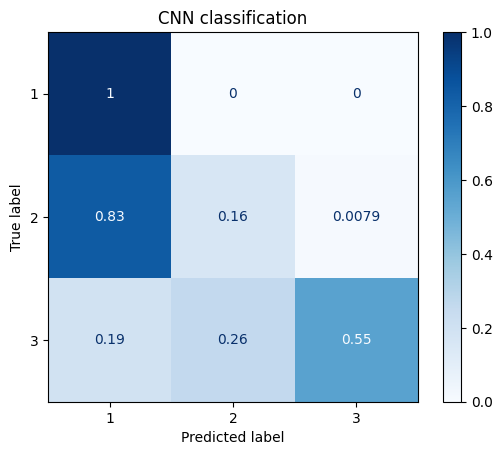

Epoch: 2/20... |  Train Loss 2.5271 |  Train Accuracy 0.6928 | Validation Loss 2.5108 |  Validation Accuracy 0.6992 | F1 score 0.6149 
Test Balanced Accuracy 0.7306 
Test F1 score 0.6556 


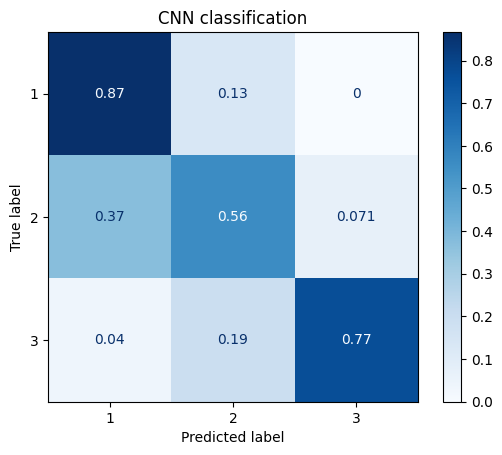

Epoch: 3/20... |  Train Loss 2.4209 |  Train Accuracy 0.7426 | Validation Loss 2.5817 |  Validation Accuracy 0.6637 | F1 score 0.5971 
Test Balanced Accuracy 0.7234 
Test F1 score 0.6566 
Epoch: 4/20... |  Train Loss 2.3043 |  Train Accuracy 0.7897 | Validation Loss 2.6451 |  Validation Accuracy 0.6548 | F1 score 0.5363 
Test Balanced Accuracy 0.6726 
Test F1 score 0.5683 
Epoch: 5/20... |  Train Loss 2.3233 |  Train Accuracy 0.7882 | Validation Loss 2.5672 |  Validation Accuracy 0.6870 | F1 score 0.6180 
Test Balanced Accuracy 0.7012 
Test F1 score 0.6310 


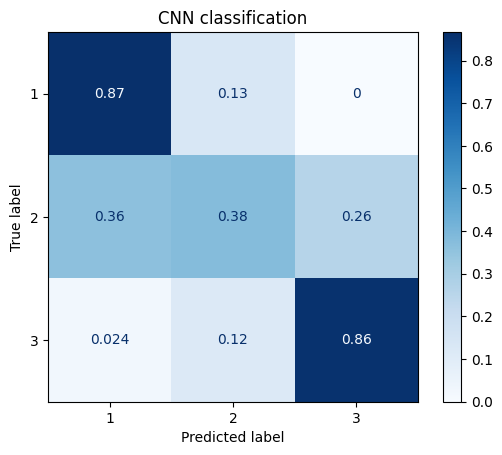

Epoch: 6/20... |  Train Loss 2.2460 |  Train Accuracy 0.8019 | Validation Loss 2.6029 |  Validation Accuracy 0.6872 | F1 score 0.6275 
Test Balanced Accuracy 0.6625 
Test F1 score 0.6260 


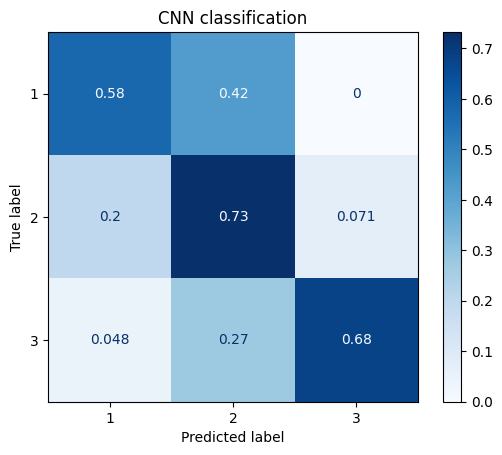

Epoch: 7/20... |  Train Loss 2.2647 |  Train Accuracy 0.8001 | Validation Loss 2.4471 |  Validation Accuracy 0.7360 | F1 score 0.6352 
Test Balanced Accuracy 0.7439 
Test F1 score 0.6758 


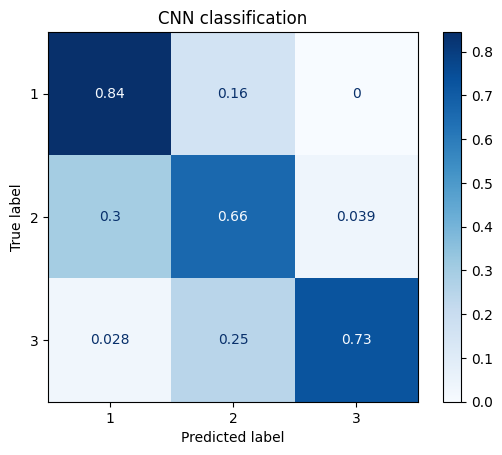

Epoch: 8/20... |  Train Loss 2.2117 |  Train Accuracy 0.8203 | Validation Loss 2.4755 |  Validation Accuracy 0.7281 | F1 score 0.6389 
Test Balanced Accuracy 0.6954 
Test F1 score 0.6323 


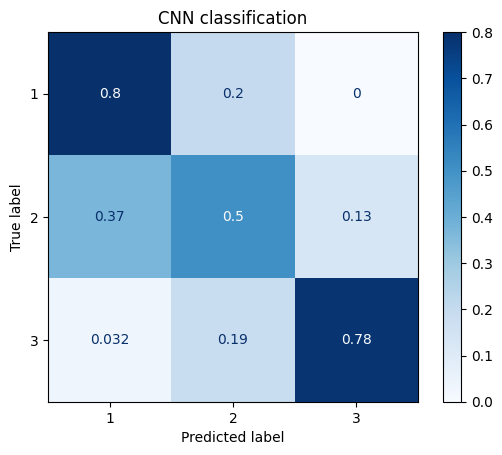

Epoch: 9/20... |  Train Loss 2.2274 |  Train Accuracy 0.8160 | Validation Loss 2.4719 |  Validation Accuracy 0.7248 | F1 score 0.6477 
Test Balanced Accuracy 0.7403 
Test F1 score 0.6799 


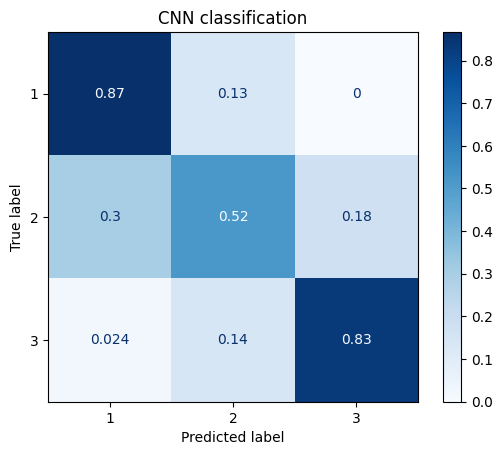

Epoch: 10/20... |  Train Loss 2.2515 |  Train Accuracy 0.8058 | Validation Loss 2.7136 |  Validation Accuracy 0.6440 | F1 score 0.5026 
Test Balanced Accuracy 0.6321 
Test F1 score 0.5020 
Epoch: 11/20... |  Train Loss 2.2223 |  Train Accuracy 0.8128 | Validation Loss 2.7052 |  Validation Accuracy 0.6390 | F1 score 0.6486 
Test Balanced Accuracy 0.6849 
Test F1 score 0.7007 


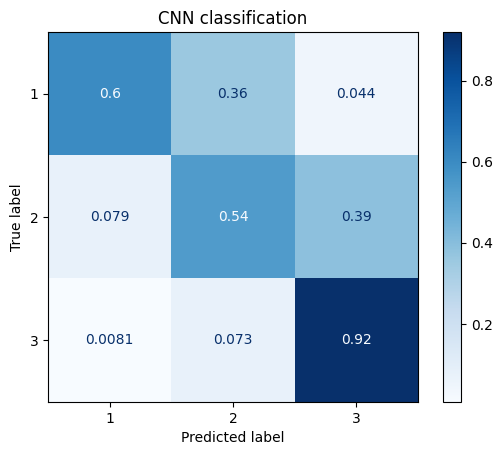

Epoch: 12/20... |  Train Loss 2.1304 |  Train Accuracy 0.8445 | Validation Loss 2.5022 |  Validation Accuracy 0.7146 | F1 score 0.6581 
Test Balanced Accuracy 0.6819 
Test F1 score 0.6373 


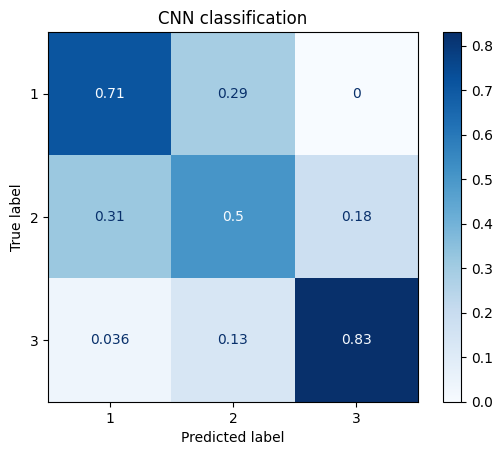

Epoch: 13/20... |  Train Loss 2.0949 |  Train Accuracy 0.8547 | Validation Loss 2.5896 |  Validation Accuracy 0.6870 | F1 score 0.6542 
Test Balanced Accuracy 0.7705 
Test F1 score 0.7295 
Epoch: 14/20... |  Train Loss 2.1605 |  Train Accuracy 0.8446 | Validation Loss 2.5104 |  Validation Accuracy 0.7015 | F1 score 0.6164 
Test Balanced Accuracy 0.6749 
Test F1 score 0.6163 
Epoch: 15/20... |  Train Loss 2.1281 |  Train Accuracy 0.8453 | Validation Loss 2.6580 |  Validation Accuracy 0.6677 | F1 score 0.6751 
Test Balanced Accuracy 0.7464 
Test F1 score 0.7456 


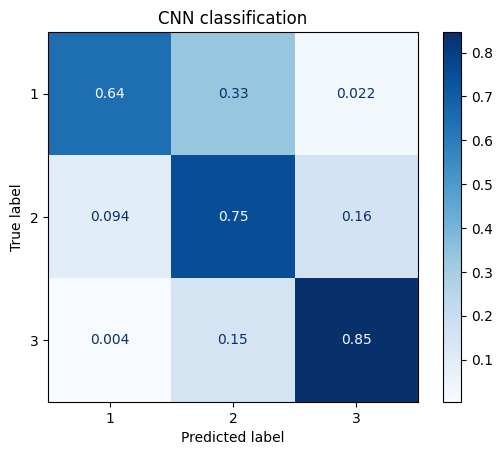

Epoch: 16/20... |  Train Loss 2.0755 |  Train Accuracy 0.8638 | Validation Loss 2.8575 |  Validation Accuracy 0.5889 | F1 score 0.5826 
Test Balanced Accuracy 0.7262 
Test F1 score 0.7200 
Epoch: 17/20... |  Train Loss 2.0902 |  Train Accuracy 0.8494 | Validation Loss 2.6616 |  Validation Accuracy 0.6646 | F1 score 0.5830 
Test Balanced Accuracy 0.6750 
Test F1 score 0.5965 
Epoch: 18/20... |  Train Loss 2.1652 |  Train Accuracy 0.8359 | Validation Loss 2.6720 |  Validation Accuracy 0.6639 | F1 score 0.5488 
Test Balanced Accuracy 0.6657 
Test F1 score 0.5678 
Epoch: 19/20... |  Train Loss 2.1093 |  Train Accuracy 0.8570 | Validation Loss 2.7590 |  Validation Accuracy 0.6306 | F1 score 0.6258 
Test Balanced Accuracy 0.7118 
Test F1 score 0.7088 
Epoch: 20/20... |  Train Loss 2.0418 |  Train Accuracy 0.8627 | Validation Loss 2.8957 |  Validation Accuracy 0.5797 | F1 score 0.5903 
Test Balanced Accuracy 0.6882 
Test F1 score 0.6972 


In [ ]:
model = make_model(ARCH, False) #True, False

# Define optimizer and loss function
criterion=nn.CrossEntropyLoss(weight = weights_classes.to('cuda'))
optimizer = optim.Adam(model.parameters(), lr=Learning_rate) #model.classifier.parameters, model.fc.parameters()


epochs = 20
if torch.cuda.is_available():model.to('cuda')
train_loss = []
#train_accuracy = []
Val_accuracy_app = []
Val_losses = []
Val_F1_app = []
Best_val_accuracy =0
Best_val_F1 = 0

for e in range(epochs):
    #train loop
    model.train()
    train_all_losses = []
    train_all_accuracies = []

    for batch in train_loader:
        optimizer.zero_grad()
        inputs, labels, id = batch
        if torch.cuda.is_available(): inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(inputs)
        labels = labels.float()
        #loss
        loss = criterion(outputs, labels)
        #accuracy
        outputs = outputs.cpu()
        labels = labels.cpu().numpy()
        outputs_np = outputs.detach().numpy()
        labels_class = np.argmax(labels, axis = 1) + 1
        outputs_class = np.argmax(outputs_np, axis = 1) +1
        accuracy = metrics.balanced_accuracy_score(labels_class, outputs_class)

        #backward pass
        loss.backward()
        optimizer.step()

        train_all_losses.append(loss.item())
        train_all_accuracies.append(accuracy.item())

    #eval loop
    model.eval()
    Val_all_losses = []
    Val_predictions = []
    Val_labels = []
    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs, val_labels, val_id = val_batch
            if torch.cuda.is_available(): val_inputs, val_labels = val_inputs.to('cuda'), val_labels.to('cuda')
            val_outputs = model(val_inputs)
            val_labels = val_labels.float()
            #loss
            val_loss = criterion(val_outputs, val_labels)
            Val_all_losses.append(val_loss.item())
            #accuracy
            val_outputs = val_outputs.cpu()
            val_labels = val_labels.cpu()
            val_outputs_np = val_outputs.detach()
            val_labels_class = np.argmax(val_labels, axis = 1) + 1
            val_outputs_class = np.argmax(val_outputs_np, axis = 1) +1

            Val_predictions.append(val_outputs_class)
            Val_labels.append(val_labels_class)

    #evaluation epoch
    Val_predictions= torch.cat(Val_predictions)
    Val_labels=torch.cat(Val_labels)
    val_accuracy = metrics.balanced_accuracy_score(Val_labels, Val_predictions)
    val_F1 = metrics.f1_score(Val_labels, Val_predictions, average = 'macro')

    Val_losses.append(np.mean(Val_all_losses))
    train_loss.append(np.mean(train_all_losses))
    Val_accuracy_app.append(val_accuracy)
    Val_F1_app.append(val_F1)


    print("Epoch: {}/{}... | ".format(e+1, epochs),
    "Train Loss {:.4f} | ".format(np.mean(train_all_losses)),
    "Train Accuracy {:.4f} |".format(np.mean(train_all_accuracies)),
    "Validation Loss {:.4f} | ".format(np.mean(Val_all_losses)),
    "Validation Accuracy {:.4f} |".format(val_accuracy),
          "F1 score {:.4f} ".format(val_F1))


    #val_confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(Val_labels, Val_predictions, normalize='true')
#### The test performance that is described in the thesis is chosen by taking the epoch with the best validation set performance!!
# If the best test set would have been used, it would not have been independent anymore.
    #test set
    #Creating test predictions
    model.eval()
    Test_predictions = []
    Test_labels = []
    with torch.no_grad():
      for test_batch in test_loader:
          test_inputs, test_labels, test_id = test_batch
          if torch.cuda.is_available(): test_inputs, test_labels = test_inputs.to('cuda'), test_labels.to('cuda')
          test_outputs = model(test_inputs)
          test_labels = test_labels.float()
          #accuracy
          test_outputs = test_outputs.cpu()
          test_labels = test_labels.cpu()#.numpy()
          test_outputs_np = test_outputs.detach()#.numpy()
          test_labels_class = np.argmax(test_labels, axis = 1) + 1
          test_outputs_class = np.argmax(test_outputs_np, axis = 1) +1

          Test_predictions.append(test_outputs_class)
          Test_labels.append(test_labels_class)

    #evaluation epoch
    Test_predictions= torch.cat(Test_predictions)
    Test_labels=torch.cat(Test_labels)
    Test_accuracy = metrics.balanced_accuracy_score(Test_labels, Test_predictions)
    test_F1 = metrics.f1_score(Test_labels, Test_predictions, average = 'macro')
    print("Test Balanced Accuracy {:.4f} ".format(Test_accuracy))
    print("Test F1 score {:.4f} ".format(test_F1))

    if val_accuracy > Best_val_accuracy or val_F1 > Best_val_F1:
      Best_val_accuracy = val_accuracy
      Best_val_F1 = val_F1
      val_confidence_matrix= metrics.ConfusionMatrixDisplay.from_predictions(Test_labels, Test_predictions, normalize='true',cmap='Blues')
      plt.title('CNN classification')
      plt.show()
